# Wildfire Data Preparation and EDA

The California Wildfire Perimeters dataset, sourced from the California Department of Forestry and Fire Protection (CALFIRE) and available through the California Natural Resources Agency GIS Data Portal, provides a comprehensive record of wildfire occurrences in California from 1950 onward. This dataset encompasses detailed information on the geographic boundaries of fires across the state, offering invaluable insights into the spatial and temporal distribution of wildfires over decades. By analyzing this data we can gain a deeper understanding of wildfire patterns, contributing factors, and impacts, which is crucial for improving fire management strategies and mitigating the effects of fires on communities and ecosystems. This dataset not only serves as a critical resource for historical analysis but also aids in predictive modeling and risk assessment in the face of increasing wildfire activity due to climate change and other environmental factors.

## Import and Clean Data

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [40]:
# Read CSV file
wildfire_data = pd.read_csv('data/California_Fire_Perimeters_(1950%2B).csv')

In [41]:
# Clean and prepare dataset

# Standardize column names
wildfire_data.columns = wildfire_data.columns.str.strip().str.lower().str.replace(' ', '_')
wildfire_data.rename(columns={'year_': 'year'}, inplace=True)

# Convert date columns to datetime
date_columns = ['alarm_date', 'cont_date']
for col in date_columns:
    wildfire_data[col] = pd.to_datetime(wildfire_data[col], errors='coerce')

# Drop years before 1980
wildfire_data = wildfire_data[wildfire_data['year'] >= 1980]

# Drop rows with invalid or missing dates
wildfire_data = wildfire_data.dropna(subset=date_columns)

# Drop unnecessary columns
drop_columns = ['irwinid', 'complex_id', 'fire_num', 'decades', 'state', 'inc_num', 'cause', 'c_method', 'objective', 'comments']
wildfire_data = wildfire_data.drop(columns=drop_columns, errors='ignore')

# Remove duplicate rows
wildfire_data = wildfire_data.drop_duplicates()

# Reset index
wildfire_data = wildfire_data.reset_index(drop=True)

Create an intensity variable that measures the severity of each wildfire on a scale from 1 to 100, incorporating the wildfire duration (cont_date - alarm_date) and the total affected acreage.

In [42]:
# Create intensity variable

# Calculate wildfire duration
wildfire_data['duration_days'] = wildfire_data['cont_date'] - wildfire_data['alarm_date']

# Drop negative durations
wildfire_data = wildfire_data[wildfire_data['duration_days'] >= pd.Timedelta(0)]

# Apply log transformation for duration and acreage
wildfire_data['log_duration'] = np.log1p(wildfire_data['duration_days'].dt.days)
wildfire_data['log_acreage'] = np.log1p(wildfire_data['gis_acres'])

# Normalize duration and acreage (using exponential scaling)
wildfire_data['normalized_duration'] = wildfire_data['log_duration'] / wildfire_data['log_duration'].max()
wildfire_data['normalized_acreage'] = wildfire_data['log_acreage'] / wildfire_data['log_acreage'].max()

# Calculate raw intensity measure (equal weights for both duration and acreage)
wildfire_data['intensity'] = 100 * (0.5 * wildfire_data['normalized_duration'] + 0.5 * wildfire_data['normalized_acreage'])

# Rescale intensity measure to scale from 1 to 100
wildfire_data['rescaled_intensity'] = round(
        1 + (wildfire_data['intensity'] - wildfire_data['intensity'].min()) /
        (wildfire_data['intensity'].max() - wildfire_data['intensity'].min()) * 99)

# Drop calculation columns
drop_columns = ['log_duration', 'log_acreage', 'normalized_duration', 'normalized_acreage']
wildfire_data = wildfire_data.drop(columns=drop_columns, errors='ignore')

In [43]:
# Save cleaned data to new CSV file
wildfire_data.to_csv('data/California_Fire_Perimeters_Cleaned.csv', index=False)

## Descriptive Statistics

In [37]:
# Summary stats for numerical data
print(wildfire_data.describe())

# Frequency of fires over years
print(wildfire_data['year'].value_counts().sort_index())

           objectid         year        cause     c_method    objective  \
count   8909.000000  8909.000000  8909.000000  8848.000000  8748.000000   
mean    4779.672915  2009.074531     7.112807     3.993671     1.022634   
std     3043.187501    10.566182     5.174694     3.043776     0.148741   
min        1.000000  1980.000000     0.000000     1.000000     1.000000   
25%     2255.000000  2004.000000     2.000000     1.000000     1.000000   
50%     4522.000000  2011.000000     7.000000     2.000000     1.000000   
75%     6827.000000  2017.000000    11.000000     7.000000     1.000000   
max    12008.000000  2023.000000    19.000000     8.000000     2.000000   

          gis_acres   shape__area  shape__length              duration_days  \
count  8.909000e+03  8.909000e+03   8.909000e+03                       8909   
mean   2.606145e+03  1.717834e+07   1.303032e+04  9 days 16:40:01.885733527   
std    2.200761e+04  1.492167e+08   5.268024e+04    43 days 00:49:56.091875   
min    1

## Visualization

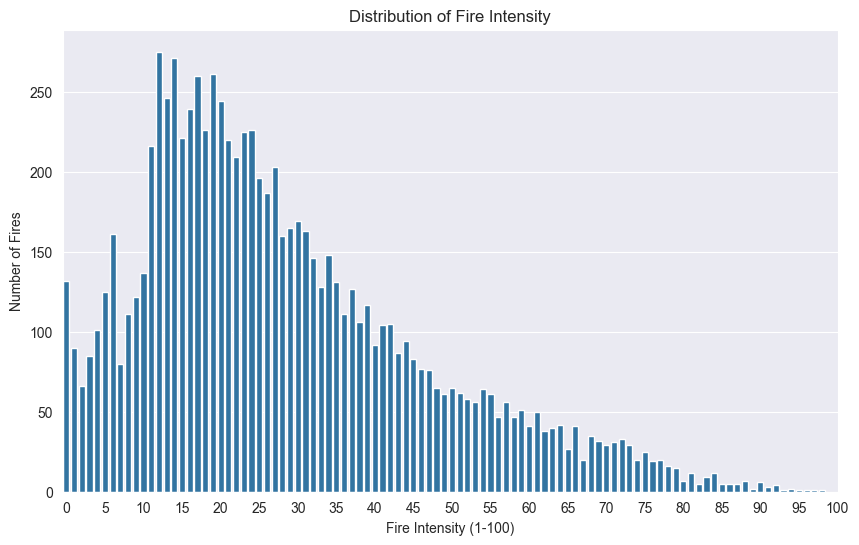

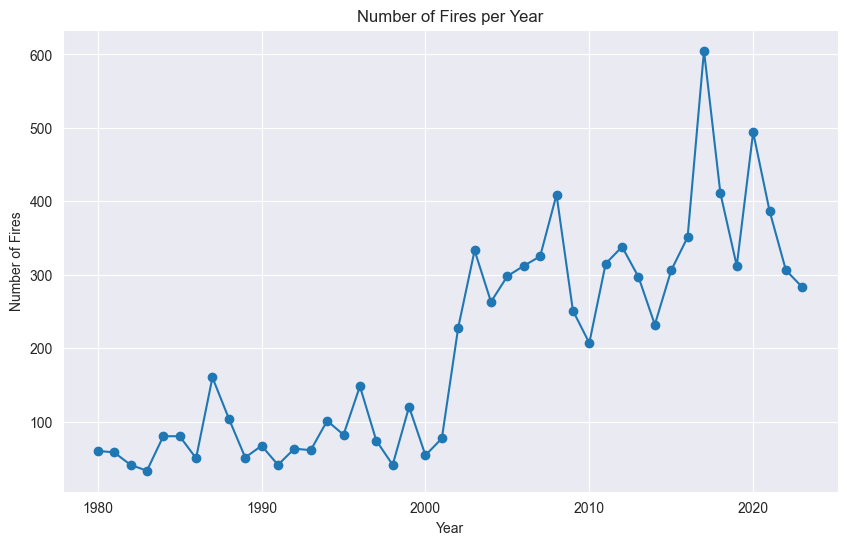

In [29]:
# Create an intensity frequency plot
plt.figure(figsize=(10, 6))
sns.countplot(x='rescaled_intensity', data=wildfire_data)
plt.title('Distribution of Fire Intensity')
plt.xlabel('Fire Intensity (1-100)')
plt.ylabel('Number of Fires')
labels = np.arange(0, 101, step=5)
plt.xticks(labels, labels=labels)

# Create time series for fire occurrences
plt.figure(figsize=(10, 6))
wildfire_data.groupby('year').size().plot(kind='line',marker='o', linestyle='-')
plt.title('Number of Fires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()